## Models, Models, Models!

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

#from extra extras
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [8]:
results = {}

### Train/Validation Split

In [11]:
#read in chosen clean data set and specify which columns to analyze
data = pd.read_csv('../data/cleaned_train.csv')
data.columns

Index(['id', 'pid', 'ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area',
       'street', 'alley', 'lot_shape', 'land_contour', 'utilities',
       'lot_config', 'land_slope', 'neighborhood', 'condition_1',
       'condition_2', 'bldg_type', 'house_style', 'overall_qual',
       'overall_cond', 'year_built', 'year_remod/add', 'roof_style',
       'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type',
       'mas_vnr_area', 'exter_qual', 'exter_cond', 'foundation', 'bsmt_qual',
       'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_sf_1',
       'bsmtfin_type_2', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf',
       'heating', 'heating_qc', 'central_air', 'electrical', '1st_flr_sf',
       '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath',
       'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr',
       'kitchen_abvgr', 'kitchen_qual', 'totrms_abvgrd', 'functional',
       'fireplaces', 'fireplace_qu', 'garage_type', 'garage_yr_blt',
       'g

In [13]:
v1_cols = ['garage_area', 
                 'total_bsmt_sf', 
                 'bsmt_full_bath', 
                 'full_bath', 
                 'bsmt_half_bath', 
                 'half_bath','overall_qual', 
                 'gr_liv_area', 
                 'year_built', 
                 'year_remod/add'
]

first_engineer_cols = ['overall_qual', 
                    'total_overall_sf', 
                    'garage_interact',
                    'years_interact',
                    'exter_qual_ord',
                    'bsmt_qual_ord',
                    'kitchen_qual_ord',
                    'lot_config', 
                    'neighborhood'
]

cols_of_interest = v1_cols

In [14]:
X = data[cols_of_interest]
y = data['saleprice']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=8)

### Null Model

Below is our RMSE score and percent variance to beat.

In [15]:
null_pred = y_train.mean()
null_train_rmse = mean_squared_error(y_train, np.full_like(y_train, null_pred), squared=False)
null_val_rmse = mean_squared_error(y_val, np.full_like(y_val, null_pred), squared=False)
print(f"Null Training RMSE: {round(null_train_rmse, 2)}")
print(f"Null Validation RMSE: {round(null_val_rmse, 2)}")
print(f"Null RMSE Variance: {round(((null_val_rmse - null_train_rmse)/null_train_rmse) * 100, 2)}%")

Null Training RMSE: 75366.81
Null Validation RMSE: 75576.08
Null RMSE Variance: 0.28%


### Iterative Modeling

#### Helper Functions

In [16]:
#could also use make_scorer
def rmse(estimator, X, y):
    '''
    Converts SkLearn's mean_squared_error function into one useable by cross_val_score
    Returns the Root Mean Squared Error of the given estimator's predictions on X, compared to y
    '''
    return mean_squared_error(y, estimator.predict(X), squared=False)

In [65]:
def print_rmse(model, y_train, y_train_pred, y_val, y_val_pred):
    '''
    Prints the training and validation Root Mean Squared Error for the given estimator with the given predictions
    Returns the Training RMSE, Validation RMSE, and Percent Variance between the two
    '''
    model_name = model.named_steps.model.regressor_
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
    percent_variance = ((val_rmse - train_rmse)/train_rmse) * 100
    
    print(f"{model} Training RMSE: {round(train_rmse, 2)}")
    print(f"{model} Validation RMSE: {round(val_rmse, 2)}")
    print(f"{model} RMSE Percent Variance: {round(percent_variance, 2)}")
    return [model, train_rmse, val_rmse, percent_variance]

#### Linear Regression

In [32]:
#adapted from class code extra-extras

ctx = ColumnTransformer(
    [('ss', StandardScaler(), X_train._get_numeric_data().columns),
    ('ohe', OneHotEncoder(handle_unknown = 'ignore'), [x for x in X_train.columns if x not in X_train._get_numeric_data().columns])
    ]
)

lr_pipe = Pipeline([
    ('ctx', ctx),
    ('model', TransformedTargetRegressor(LinearRegression(), func=np.log, inverse_func=np.exp))
])

lr_pipe.fit(X_train, y_train)

#predict
lr_train_preds = lr_pipe.predict(X_train)
lr_val_preds = lr_pipe.predict(X_val)

#evaluate
results[str(cols_of_interest)] = [print_rmse(lr_pipe, y_train, lr_train_preds, y_val, lr_val_preds)]


LinearRegression() Training RMSE: 24451.42
LinearRegression() Validation RMSE: 25784.37
LinearRegression() RMSE Percent Variance: 5.45


In [35]:
#check the train test split
cross_val_score(lr_pipe, X_train, y_train, scoring=rmse)

array([28250.4253945 , 23599.14243977, 22540.53786407, 25840.16036112,
       23685.53350049])

In [34]:
results[str(cols_of_interest)][0][0].predict(X_train)

array([554.28526129, 489.85522153, 516.16228758, ..., 609.44852688,
       453.84757553, 496.72102006])

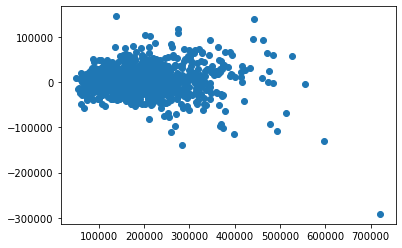

In [109]:
#check for LINE assumptions
plt.scatter(lr_train_preds, y_train - lr_train_preds)

#### Lasso

In [58]:
#adapted from class code extra-extras
ctx = ColumnTransformer(
    [('ss', StandardScaler(), X_train._get_numeric_data().columns),
    ('ohe', OneHotEncoder(handle_unknown = 'ignore'), [x for x in X_train.columns if x not in X_train._get_numeric_data().columns])
])

lasso_pipe = Pipeline([
    ('ctx', ctx),
    ('model', TransformedTargetRegressor(Lasso(), func=np.log, inverse_func=np.exp))
])

lasso_params = {
    'ctx__remainder' : ['passthrough'], # keep untransformed columns
    'model__regressor__alpha' : np.linspace(.001, 10, 100),
    'model__regressor__max_iter' : [10000]
}

In [59]:
lasso_gs = GridSearchCV(lasso_pipe, 
                        lasso_params, 
                        scoring='neg_root_mean_squared_error').fit(X_train, y_train)


In [60]:
lasso_train_preds = lasso_gs.predict(X_train)
lasso_val_preds = lasso_gs.predict(X_val)
results[str(cols_of_interest)].append(print_rmse(lasso_gs.best_estimator_,
                                                y_train,
                                                lasso_train_preds,
                                                y_val,
                                                lasso_val_preds))


Lasso(alpha=0.001, max_iter=10000) Training RMSE: 24474.92
Lasso(alpha=0.001, max_iter=10000) Validation RMSE: 25811.98
Lasso(alpha=0.001, max_iter=10000) RMSE Percent Variance: 5.46


In [64]:
lasso_gs.best_estimator_.predict(X_val) == lasso_gs.predict(X_val)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

#### Ridge

In [61]:
#adapted from class code extra-extras

ctx = ColumnTransformer(
    [('ss', StandardScaler(), X_train._get_numeric_data().columns),
    ('ohe', OneHotEncoder(handle_unknown = 'ignore'), [x for x in X_train.columns if x not in X_train._get_numeric_data().columns])
    ]
)

ridge_pipe = Pipeline([
    ('ctx', ctx),
    ('model', TransformedTargetRegressor(regressor=Ridge(), func=np.log, inverse_func=np.exp))
])

ridge_params = {
    'ctx__remainder' : ['passthrough'], # keep untransformed columns
    'model__regressor__alpha' : np.linspace(1, 1000, num=100)
}

In [62]:
ridge_gs = GridSearchCV(ridge_pipe, ridge_params, scoring='neg_root_mean_squared_error').fit(X_train, y_train)


In [63]:
ridge_train_preds = ridge_gs.predict(X_train)
ridge_val_preds = ridge_gs.predict(X_val)
results[str(cols_of_interest)].append(print_rmse(ridge_gs.best_estimator_,
                                                y_train,
                                                ridge_train_preds,
                                                y_val,
                                                ridge_val_preds))

Ridge() Training RMSE: 24452.02
Ridge() Validation RMSE: 25784.88
Ridge() RMSE Percent Variance: 5.45


In [ ]:
#cross_val_score(ridge_gs, X_train, y_train, scoring=rmse)

### Kaggle Submission

In [74]:
results

{"['garage_area', 'total_bsmt_sf', 'bsmt_full_bath', 'full_bath', 'bsmt_half_bath', 'half_bath', 'overall_qual', 'gr_liv_area', 'year_built', 'year_remod/add']": [[LinearRegression(),
   24451.420803824098,
   25784.36701176228,
   5.451405947460174],
  [Ridge(), 24452.020312938705, 25784.884320464756, 5.450936120892928],
  [Ridge(), 24452.020312938705, 25784.884320464756, 5.450936120892928],
  [Lasso(alpha=0.0001, max_iter=10000),
   24452.22703578358,
   25785.733678813885,
   5.4535181645370825],
  [Lasso(alpha=0.001, max_iter=10000),
   24474.923390980122,
   25811.982887577098,
   5.462977249153432]]}

In [76]:
test = pd.read_csv("../data/cleaned_test.csv")

best_model = None

sorted_results = {val.sort(key=lambda x: x[-2]) for val in results.values()}
    
results

{"['garage_area', 'total_bsmt_sf', 'bsmt_full_bath', 'full_bath', 'bsmt_half_bath', 'half_bath', 'overall_qual', 'gr_liv_area', 'year_built', 'year_remod/add']": [[LinearRegression(),
   24451.420803824098,
   25784.36701176228,
   5.451405947460174],
  [Ridge(), 24452.020312938705, 25784.884320464756, 5.450936120892928],
  [Ridge(), 24452.020312938705, 25784.884320464756, 5.450936120892928],
  [Lasso(alpha=0.0001, max_iter=10000),
   24452.22703578358,
   25785.733678813885,
   5.4535181645370825],
  [Lasso(alpha=0.001, max_iter=10000),
   24474.923390980122,
   25811.982887577098,
   5.462977249153432]]}

In [77]:
sorted_results

{None}